<a href="https://colab.research.google.com/github/iamscj/fakenewsdetection/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot

In [ ]:
import pandas as pd

In [ ]:
def read_dataframe(tsv_file: str) -> pd.DataFrame: # .tsv to df

    # creates a "dataframe" or "df" for short. This is similar to a 2-D python dict.
    df = pd.read_csv(tsv_file, delimiter='\t', dtype=object)

    # replaces all "null" or "NaN" values with an empty string
    df.fillna("", inplace=True)

    # labels the columns in the dataset using the data dictionary described in the README
    df.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'title',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'author',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.

        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.

        'context' # Column 14: the context (venue / location of the speech or statement).
    ]

    return df

#create a dataframe from the training data
df = read_dataframe('/content/drive/MyDrive/FakeNewsDataset/train.tsv')

In [ ]:
df['title'][0]

'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'

In [ ]:
df['label'] = df['label'].apply(lambda x: 0 if x in ['mostly-true', 'true'] else 1)
df.head()

,id,label,title,subjects,author,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
1,324.json,0,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
2,1123.json,1,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7,19,3,5,44,a news release
3,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15,9,20,19,2,an interview on CNN
4,12465.json,0,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0,3,2,5,1,a an online opinion-piece


In [ ]:
###Drop Nan Values
df=df.dropna()

In [ ]:
## Get the Independent Features

X=df.drop('label',axis=1)

In [ ]:
## Get the Dependent features
y=df['label']

In [ ]:
y.value_counts()

1    6601
0    3638
Name: label, dtype: int64

In [ ]:
X.shape

(10239, 13)

In [ ]:
y.shape

(10239,)

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [ ]:
### Vocabulary size
voc_size=5000

In [ ]:
messages=X.copy()

In [ ]:
messages['title'][0]

'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'

In [ ]:
#reset the index in messages as nan values are dropped
messages.reset_index(inplace=True)

In [ ]:
import nltk
import re
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Preprocessing of Data**
**Role of Stemming** : The role of stemming is to normalize words so that different forms of the same word are treated as identical, even if they have different suffixes or prefixes.

In [ ]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):

    #replace unnecessary characters with spaces using regex
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])

    #lower
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

print(len(messages))

10239


In [ ]:
corpus[0:5]

['declin coal start start natur ga took start begin presid georg w bush administr',
 'hillari clinton agre john mccain vote give georg bush benefit doubt iran',
 'health care reform legisl like mandat free sex chang surgeri',
 'econom turnaround start end term',
 'chicago bear start quarterback last year total number tenur uw faculti fire last two decad']

In [ ]:
onehot_repr=[one_hot(words,voc_size)for words in corpus]
# onehot_repr

In [ ]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ...  834  198 4269]
 [   0    0    0 ... 4598 3054 3270]
 [   0    0    0 ... 1535 2629  333]
 ...
 [   0    0    0 ... 3529 2721 4778]
 [   0    0    0 ... 2550 2211 2793]
 [   0    0    0 ... 3755 1142 1382]]


In [ ]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,  683, 4483, 4719, 4719,  979,
       4170, 1961, 4719, 3078, 3588, 1721,  834,  198, 4269], dtype=int32)

# Creating The Model (LSTM)

In [ ]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100)) # 100 neurons, so if this increases acc incr later overfitting
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) # adam optimizer change the parameters for training
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256501 (1001.96 KB)
Trainable params: 256501 (1001.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
len(embedded_docs),y.shape

(10239, (10239,))

In [ ]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [ ]:
X_final.shape,y_final.shape

((10239, 20), (10239,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# **Model Training**


In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64) # 64 words for each epoch

Epoch 1/10
108/108 [==============================] - 42s 257ms/step - loss: 0.6524 - accuracy: 0.6442 - val_loss: 0.6380 - val_accuracy: 0.6431
Epoch 2/10
108/108 [==============================] - 4s 40ms/step - loss: 0.5927 - accuracy: 0.6827 - val_loss: 0.6413 - val_accuracy: 0.6529
Epoch 3/10
108/108 [==============================] - 2s 21ms/step - loss: 0.5252 - accuracy: 0.7309 - val_loss: 0.6985 - val_accuracy: 0.6212
Epoch 4/10
108/108 [==============================] - 3s 24ms/step - loss: 0.4683 - accuracy: 0.7649 - val_loss: 0.7214 - val_accuracy: 0.6363
Epoch 5/10
108/108 [==============================] - 2s 14ms/step - loss: 0.4113 - accuracy: 0.8047 - val_loss: 0.7272 - val_accuracy: 0.6215
Epoch 6/10
108/108 [==============================] - 2s 16ms/step - loss: 0.3582 - accuracy: 0.8360 - val_loss: 0.9224 - val_accuracy: 0.5892
Epoch 7/10
108/108 [==============================] - 2s 19ms/step - loss: 0.3123 - accuracy: 0.8609 - val_loss: 1.1227 - val_accuracy: 0.60

In [ ]:
import matplotlib.pyplot as plt

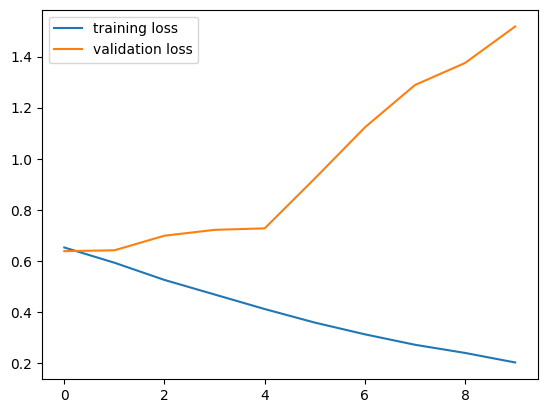

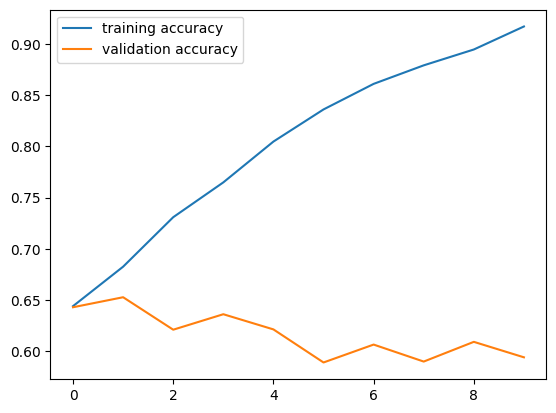

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [ ]:
# Save the model to a file
model.save('/content/drive/MyDrive/FakenewsModel/fake_news_predict.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

106/106 [==============================] - 1s 2ms/step


# **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test,y_pred)

array([[ 541,  665],
       [ 706, 1467]])

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

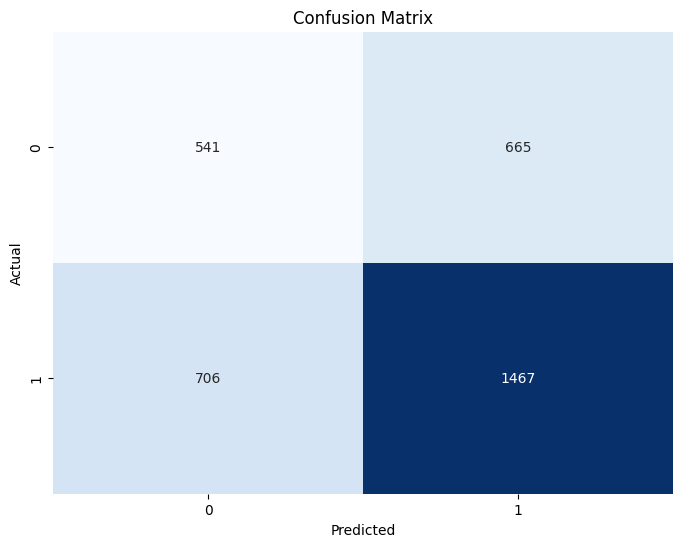

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.5942586564072211

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    ps = PorterStemmer()
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review


# Function to predict
def predict_statement(statement, model):
    voc_size = 5000
    sent_length = 20

    # Preprocess the user input
    processed_statement = preprocess_text(statement)

    # One-hot encode the preprocessed statement
    input_data = [one_hot(processed_statement, voc_size)]
    padded_input = pad_sequences(input_data, padding='pre', maxlen=sent_length)

    # Make a prediction
    prediction = model.predict(np.array(padded_input))

    # Convert prediction to 0 or 1
    prediction = (prediction > 0.5).astype(int)

    return prediction[0][0]

In [ ]:
# # Load the pre-trained model
# model = load_model()

# Take input from the user
# user_input = input("Enter a statement: ")

#example 1 (real news)
# user_input = """Hillary Clinton agrees with John McCain
# "by voting to give George Bush the benefit of the doubt on Iran."""


# example 2 (fake news)
user_input = """Health care reform legislation is likely to mandate free sex change surgeries."""
# Predict the label (0 or 1)
result = predict_statement(user_input, model)

if result == 0:
    print("The statement is mostly true or true.")
else:
    print("The statement is false or barely true.")

1/1 [==============================] - 0s 19ms/step
The statement is false or barely true.


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/FakenewsModel/fake_news_predict.h5')

In [ ]:
#example 1 (real news)
user_input = """Hillary Clinton agrees with John McCain
"by voting to give George Bush the benefit of the doubt on Iran."""

result = predict_statement(user_input, loaded_model)

if result == 0:
    print("The statement is mostly true or true.")
else:
    print("The statement is false or barely true.")

1/1 [==============================] - 0s 338ms/step
The statement is mostly true or true.


In [ ]:
#example 2 (real news)
user_input = """Karnataka bandh: Cabs, autos off roads, chaos at airport, several detained"""

result = predict_statement(user_input, loaded_model)

if result == 0:
    print("The statement is mostly true or true.")
else:
    print("The statement is false or barely true.")

1/1 [==============================] - 0s 18ms/step
The statement is mostly true or true.


## **Using Transformer Model**

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize your text data
inputs = tokenizer(df['title'].tolist(), padding=True, truncation=True, return_tensors="tf")

# Create TensorFlow datasets
dataset = tf.data.Dataset.from_tensor_slices((dict(inputs), y))
dataset = dataset.shuffle(len(dataset)).batch(8)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
modelTransformerModel = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

modelTransformerModel.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = modelTransformerModel.fit(dataset, epochs=3)

Epoch 1/3
1280/1280 [==============================] - 1248s 907ms/step - loss: 0.6364 - accuracy: 0.6433
Epoch 2/3
1280/1280 [==============================] - 1164s 909ms/step - loss: 0.6005 - accuracy: 0.6726
Epoch 3/3
1280/1280 [==============================] - 1163s 909ms/step - loss: 0.5196 - accuracy: 0.7348


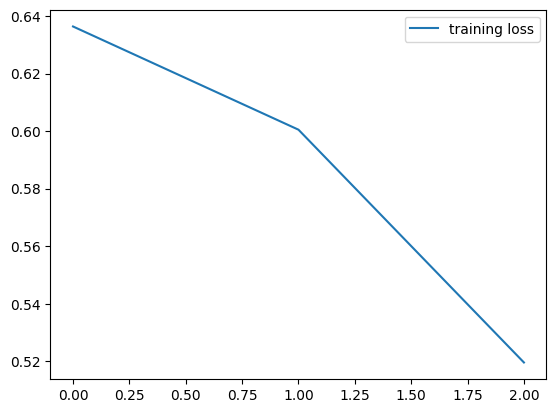

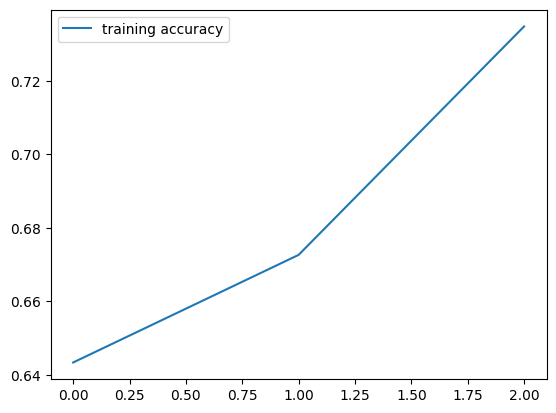

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='training accuracy')
plt.legend()
plt.show()

# **Confusion Matrix and Accuracy**

1280/1280 [==============================] - 420s 328ms/step


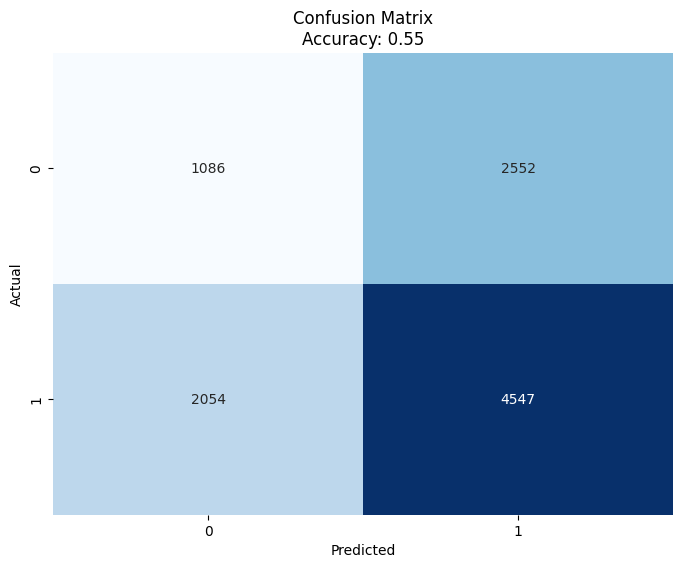

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = modelTransformerModel.predict(dataset)
y_pred = np.argmax(y_pred.logits, axis=1)

y_true = np.concatenate([y for x, y in dataset])

confusion_mat = confusion_matrix(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
plt.show()

# **Accuracy of Transformer Model**

In [ ]:
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.53


# **Saving the weights and model for Transformer Model**

In [ ]:
# Save model weights
modelTransformerModel.save_weights('/content/drive/MyDrive/FakenewsModel/fake_news_predict_with_transformer_weights.h5')

# Load model weights
modelTransformerModel.load_weights('/content/drive/MyDrive/FakenewsModel/fake_news_predict_with_transformer_weights.h5')


In [ ]:
modelTransformerModel.save('/content/drive/MyDrive/FakenewsModel/fake_news_predict_with_transformer_model', save_format="tf")

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/FakenewsModel/fake_news_predict_with_transformer_model')

# **Prediction by Loading the transformer Model**

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from google.colab import drive
drive.mount('/content/drive')

modelLoaded = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
modelLoaded.load_weights('/content/drive/MyDrive/FakenewsModel/fake_news_predict_with_transformer_weights.h5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
user_input = """Hillary Clinton agrees with John McCain
"by voting to give George Bush the benefit of the doubt on Iran."""

text = user_input

inputs = tokenizer(text, padding=True, truncation=True, return_tensors="tf")

In [ ]:
prediction = modelLoaded(inputs)

In [ ]:
predicted_label = tf.argmax(prediction.logits, axis=1).numpy()[0]

In [ ]:
probabilities = tf.nn.softmax(prediction.logits, axis=1).numpy()[0]

In [ ]:
print(probabilities)

[0.60016394 0.399836  ]


In [ ]:
if probabilities[0] >= 0.5:
    print("The statement is mostly true or true.")
else:
    print("The statement is false or barely true.")

The statement is mostly true or true.


# **Using SimpleRNN Model**

In [ ]:
from tensorflow.keras.layers import SimpleRNN

# Creating model
embedding_vector_features = 40
modelSimpleRNN = Sequential()
modelSimpleRNN.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
modelSimpleRNN.add(SimpleRNN(100))

modelSimpleRNN.add(Dense(1, activation='sigmoid'))
modelSimpleRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelSimpleRNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            200000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               14100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 214201 (836.72 KB)
Trainable params: 214201 (836.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = modelSimpleRNN.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
108/108 [==============================] - 25s 184ms/step - loss: 0.6577 - accuracy: 0.6423 - val_loss: 0.6517 - val_accuracy: 0.6431
Epoch 2/10
108/108 [==============================] - 5s 48ms/step - loss: 0.5655 - accuracy: 0.7028 - val_loss: 0.7030 - val_accuracy: 0.5709
Epoch 3/10
108/108 [==============================] - 4s 35ms/step - loss: 0.3581 - accuracy: 0.8469 - val_loss: 0.8950 - val_accuracy: 0.5629
Epoch 4/10
108/108 [==============================] - 5s 50ms/step - loss: 0.1894 - accuracy: 0.9248 - val_loss: 1.1322 - val_accuracy: 0.5582
Epoch 5/10
108/108 [==============================] - 6s 60ms/step - loss: 0.1116 - accuracy: 0.9617 - val_loss: 1.4289 - val_accuracy: 0.5664
Epoch 6/10
108/108 [==============================] - 5s 43ms/step - loss: 0.0744 - accuracy: 0.9781 - val_loss: 1.5985 - val_accuracy: 0.5741
Epoch 7/10
108/108 [==============================] - 5s 47ms/step - loss: 0.0397 - accuracy: 0.9891 - val_loss: 1.9694 - val_accuracy: 0.57

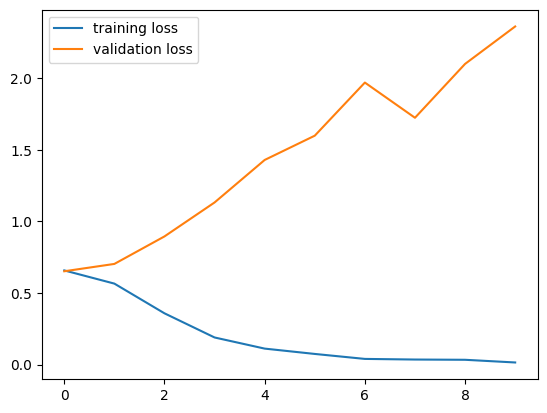

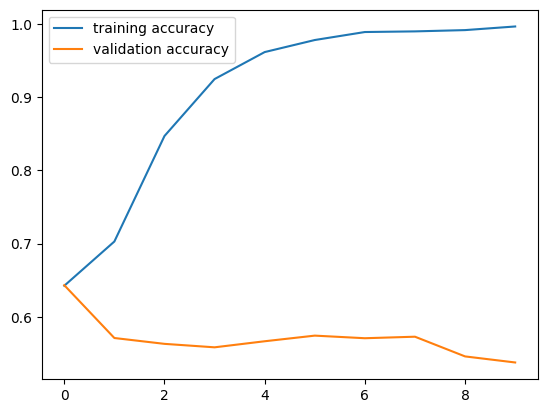

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

GRU *Gated Recurrent Unit*

In [ ]:
from tensorflow.keras.layers import GRU

# Creating model
embedding_vector_features = 40
modelGRU = Sequential()
modelGRU.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
modelGRU.add(GRU(100))
modelGRU.add(Dense(1, activation='sigmoid'))
modelGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelGRU.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 40)            200000    
                                                                 
 gru (GRU)                   (None, 100)               42600     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 242701 (948.05 KB)
Trainable params: 242701 (948.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = modelGRU.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
108/108 [==============================] - 22s 150ms/step - loss: 0.6518 - accuracy: 0.6440 - val_loss: 0.6413 - val_accuracy: 0.6431
Epoch 2/10
108/108 [==============================] - 5s 45ms/step - loss: 0.5964 - accuracy: 0.6764 - val_loss: 0.6468 - val_accuracy: 0.6505
Epoch 3/10
108/108 [==============================] - 2s 19ms/step - loss: 0.5145 - accuracy: 0.7439 - val_loss: 0.6833 - val_accuracy: 0.6389
Epoch 4/10
108/108 [==============================] - 1s 14ms/step - loss: 0.4492 - accuracy: 0.7860 - val_loss: 0.7582 - val_accuracy: 0.6017
Epoch 5/10
108/108 [==============================] - 1s 13ms/step - loss: 0.3889 - accuracy: 0.8184 - val_loss: 0.8728 - val_accuracy: 0.5949
Epoch 6/10
108/108 [==============================] - 1s 14ms/step - loss: 0.3437 - accuracy: 0.8448 - val_loss: 1.0228 - val_accuracy: 0.6049
Epoch 7/10
108/108 [==============================] - 1s 11ms/step - loss: 0.3022 - accuracy: 0.8679 - val_loss: 1.0778 - val_accuracy: 0.59

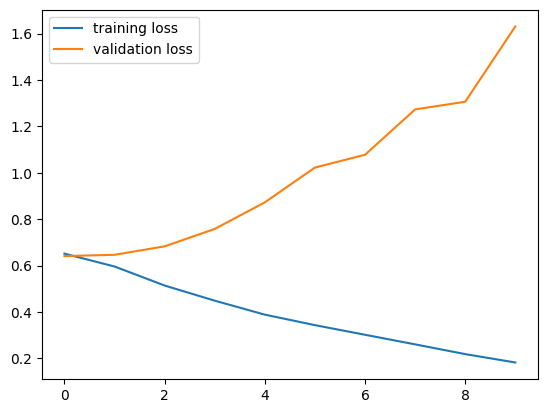

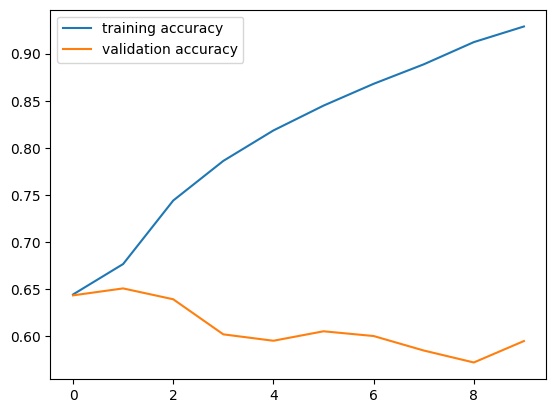

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [ ]:
# Save the model to a file
modelSimpleRNN.save('/content/drive/MyDrive/FakenewsModel/fake_news_predict_with_simple_rnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
modelGRU.save('/content/drive/MyDrive/FakenewsModel/fake_news_predict_with_gru_model.h5')

# **Confusion Matrix for SimpleRNN**

In [ ]:
y_pred_prob = modelSimpleRNN.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

106/106 [==============================] - 1s 5ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
conf_matrix

array([[ 519,  687],
       [ 876, 1297]])

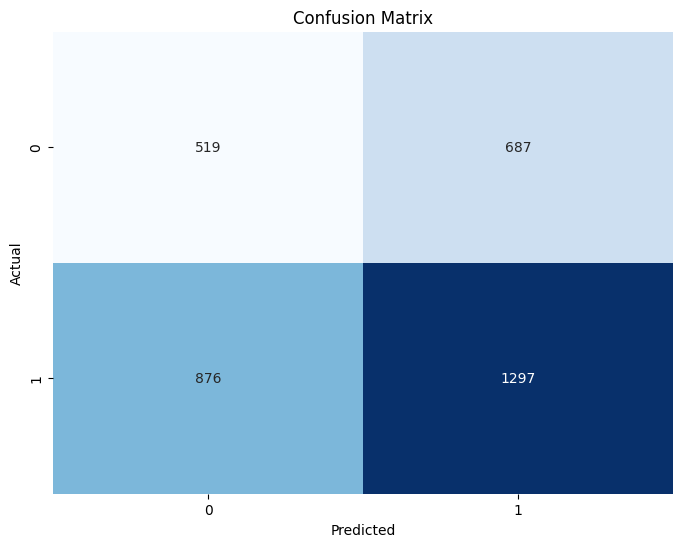

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Accuracy of SimpleRNN**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.5374371115714709

# **Confusion Matrix for GRU Model**

In [ ]:
y_pred_prob = modelGRU.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

106/106 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
conf_matrix

array([[ 488,  718],
       [ 652, 1521]])

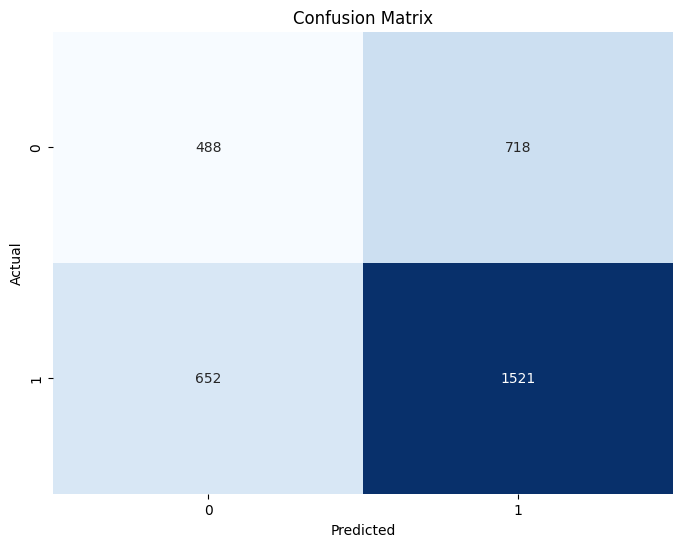

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Accuracy of GRUModel**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.5945546019532406

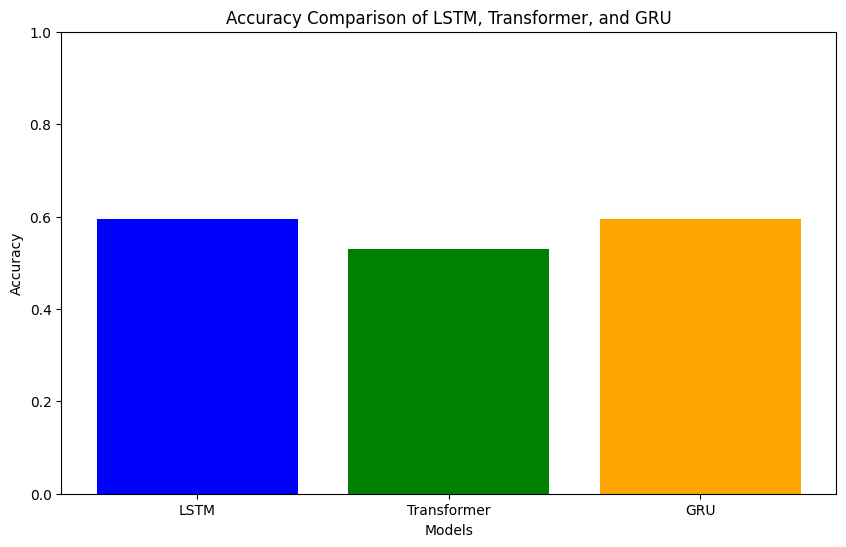

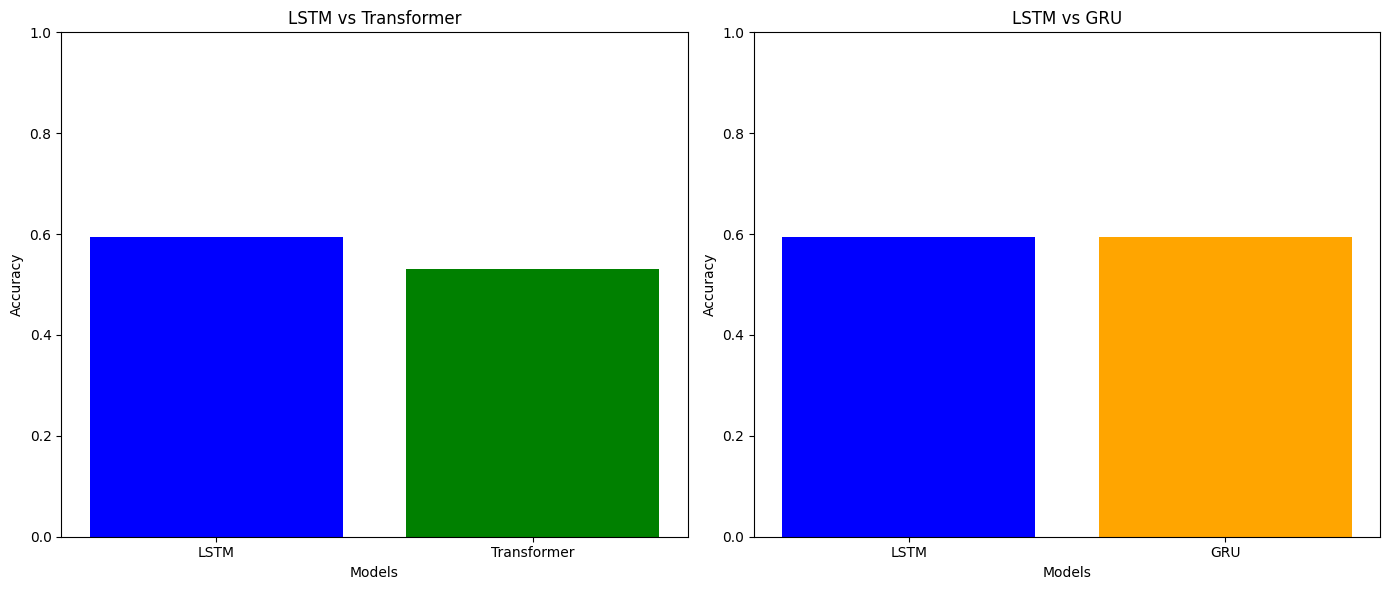

In [ ]:
lstm_acc = 0.5942586564072211
transformer_acc = 0.53
gru_acc = 0.5945546019532406

import matplotlib.pyplot as plt

models = ['LSTM', 'Transformer', 'GRU']
accuracy_values = [lstm_acc, transformer_acc, gru_acc]

# Plotting all at once
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_values, color=['blue', 'green', 'orange'])
plt.title('Accuracy Comparison of LSTM, Transformer, and GRU')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot LSTM vs Transformer
axes[0].bar(['LSTM', 'Transformer'], [lstm_acc, transformer_acc], color=['blue', 'green'])
axes[0].set_title('LSTM vs Transformer')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)

# Plot LSTM vs GRU
axes[1].bar(['LSTM', 'GRU'], [lstm_acc, gru_acc], color=['blue', 'orange'])
axes[1].set_title('LSTM vs GRU')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

LSTM has highest accuracy